In [1]:
import io
import pathlib
import re
import tarfile

import numpy as np
import pandas as pd
import scipy.io
import tqdm

In [2]:
# Define the root of the directory of interest
path = pathlib.Path('/data1/home/rav7008/formike/')

# Data errors and data quality
1. Age
    1. Unreasonable ages and `NaN`
2. Sex
    1. Too many options and ambiguity when multiple/none listed
3. Drugs
    1. Repeats in the `unique_ingredients.npy` file (not unique!)
    1. Some do not have RxNorm CUIs in the file
        1. Ambiguity what to do with `drug_concept_id`. What fields *should* be present in drug table?
4. `NaN` in PRR files
    1. What is the meaning of this? Why would they be `NaN`?
5. Why `metadata['reportids'] != metadata['reportids_IN']`?

# 1. Age

In [3]:
ages = np.load(path / 'data/all_ages.npy', allow_pickle=True)

ages_df = (
    pd.DataFrame
    .from_dict(ages.item(), orient='index')
    .reset_index()
    .rename(columns={'index': 'report_id', 0: 'age'})
)

(
    ages_df
    .loc[(ages_df['age'] < 0) | (ages_df['age'] > 110)]
    .sort_values(by='age', ascending=False)
    .head(20)
)

,report_id,age
2043937,4381869,7200
1986616,4315400,6800
517178,4352281,5200
4029827,6974212,1054
4039709,6986289,1045
655486,93530001,1005
2142467,88385041,958
397987,7104578,953
1991583,4321047,869
1780051,4842004,660


# 2. Sex

In [4]:
sexes = np.load(path / 'data/all_sexes.npy', allow_pickle=True)

sexes_df = (
    pd.Series(sexes.item())
    .reset_index()
    .rename(columns={'index': 'report_id', 0: 'sex'})
)

In [5]:
sexes_df['sex'].value_counts()

[F]           4937117
[M]           3126543
[]             657841
[NS]           109382
[UNK]           14581
[F, F]           2701
[M, M]           1900
[, ]              180
[UNK, UNK]         21
[, M]              10
[, F]               6
[M, F]              6
[NS, NS]            6
[NS, M]             5
[F, M]              5
[YR]                1
[, NS]              1
[NS, ]              1
Name: sex, dtype: int64

# 3. Drugs

### A. Drugs appear to be redundant within the vector (some drugs appear at a number of different indices).

In [6]:
unique_ingredients = np.load(path / 'data/unique_ingredients.npy')

(
    pd.Series(unique_ingredients.astype(int))
    .value_counts()
    .head(20)
)

161      44
5487     28
8163     21
8896     20
3289     20
6750     17
1886     17
1191     16
1897     15
2400     13
4124     12
5492     12
3498     11
5032     11
1151     10
1952     10
17767    10
5640      9
68244     8
11423     8
dtype: int64

### B. `drug_concept_names.csv` does not include names and concept ids for all the ingredients in the vector

In [7]:
drug_names = pd.read_csv(path / 'data/drug_concept_names.csv')

(
    drug_names
    .merge(pd.Series(unique_ingredients.astype(int), name='concept_code'), how='right')
    .query('concept_name.isnull()')
)

,drug_concept_id,concept_name,concept_code
4386,NaN,NaN,100278
4387,NaN,NaN,857953
4388,NaN,NaN,1427022
4389,NaN,NaN,1303851
4390,NaN,NaN,1304122
4391,NaN,NaN,386055
4392,NaN,NaN,1731071
4393,NaN,NaN,596723
4394,NaN,NaN,1727875
4395,NaN,NaN,644634


# 4. `NaN` in PRR files

In [8]:
# Open the tarfile containing all computed PRR and PRR error values
tf = tarfile.open(path / 'all_PRRs.tar.gz', mode='r:gz')

# Only currently interested in the PRR files, not errors, though there are NaNs there too
prr_files = [path for path in tf.getmembers() if 'PRRs' not in path.name]

non_na_frac = list()
for member in prr_files:
    npy = tf.extractfile(member)
    prr = np.load(io.BytesIO(npy.read())).flatten()
    
    if not np.isnan(prr[0]):
        print(member.name)
        
    fraction_non_na = (prr.shape[0] - prr[np.isnan(prr)].shape[0]) / prr.shape[0]
    non_na_frac.append((member.name, fraction_non_na))
    
non_na_df = pd.DataFrame(non_na_frac, columns=['filename', 'frac_non_na'])

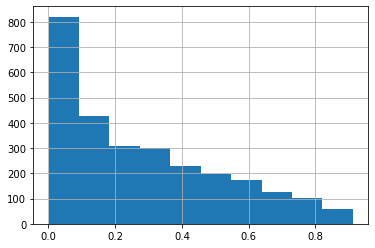

In [9]:
# x-axis is the fraction of values that are NOT NaN among PRR files
# y-axis is the number of PRR files with that fraction of non-NaN

%matplotlib inline
non_na_df['frac_non_na'].hist()

# 5. Report ID ambiguity

In [10]:
report_id = np.load(path / 'data/all_reportids.npy')
report_id_in = np.load(path / 'data/all_reportids_IN.npy')

report_id.shape, report_id_in.shape

((4855498,), (4694086,))